In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import random

In [2]:
import pathlib
data_dir = pathlib.Path("training-data")


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2665


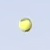

In [4]:
spikeballs = list(data_dir.glob('spikeballs/*'))
PIL.Image.open(str(spikeballs[10]))

In [5]:
batch_size = 32
img_height = 50
img_width = 50

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2665 files belonging to 2 classes.
Using 2132 files for training.
Found 2665 files belonging to 2 classes.
Using 533 files for validation.


2021-11-18 15:02:14.446460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
class_names = train_ds.class_names
print(class_names)

['non-spikeballs', 'spikeballs']


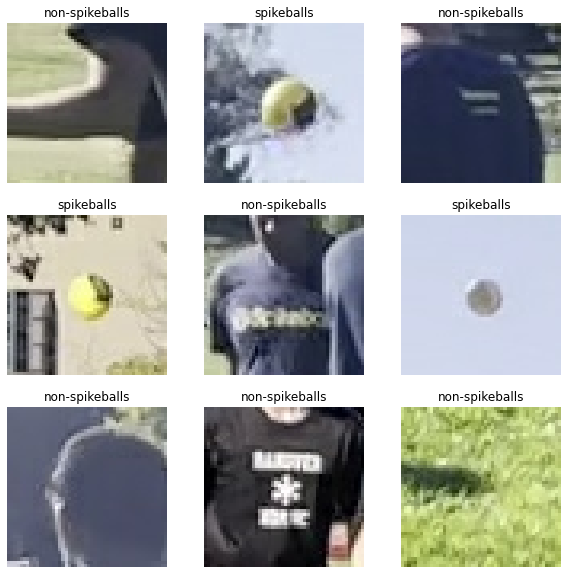

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

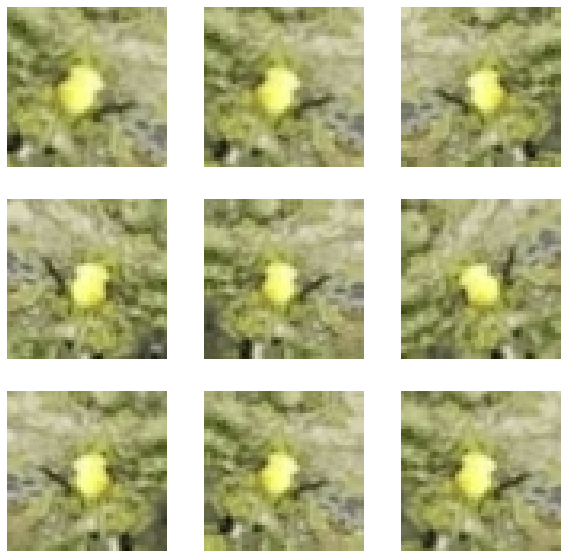

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 50, 50, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

In [12]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
67/67 [==============================] - 3s 31ms/step - loss: 0.4838 - accuracy: 0.7674 - val_loss: 0.3375 - val_accuracy: 0.9231
Epoch 2/15
67/67 [==============================] - 2s 30ms/step - loss: 0.2292 - accuracy: 0.9264 - val_loss: 0.2003 - val_accuracy: 0.9475
Epoch 3/15
67/67 [==============================] - 2s 30ms/step - loss: 0.1655 - accuracy: 0.9531 - val_loss: 0.1292 - val_accuracy: 0.9681
Epoch 4/15
67/67 [==============================] - 2s 35ms/step - loss: 0.1386 - accuracy: 0.9573 - val_loss: 0.1197 - val_accuracy: 0.9700
Epoch 5/15
67/67 [==============================] - 2s 37ms/step - loss: 0.1291 - accuracy: 0.9648 - val_loss: 0.1475 - val_accuracy: 0.9493
Epoch 6/15
67/67 [==============================] - 2s 34ms/step - loss: 0.1374 - accuracy: 0.9620 - val_loss: 0.1086 - val_accuracy: 0.9737
Epoch 7/15
67/67 [==============================] - 2s 35ms/step - loss: 0.1357 - accuracy: 0.9606 - val_loss: 0.1198 - val_accuracy: 0.9812
Epoch 8/15
67

In [13]:
# Lets go ahead and do some predicting 
# lets pick a random image from the training set 
unclass_data_path = pathlib.Path("unclassified-data")
options = list(unclass_data_path.glob('*/*.jpg'))



unclassified-data/unclassified-spikeball-5/spikeball_5_6930.jpg
tf.Tensor([0.02111368 0.97888625], shape=(2,), dtype=float32)
[[-2.535529   1.3009654]]
This image most likely belongs to spikeballs with a 97.89 percent confidence.


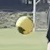

In [17]:
chosen_path = random.choice(options)
print(chosen_path)

img = tf.keras.utils.load_img(
    chosen_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(chosen_path))

tf.Tensor([0.0673888  0.93261117], shape=(2,), dtype=float32)
[[-1.7892398  0.8382697]]
This image most likely belongs to spikeballs with a 93.26 percent confidence.


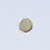

In [18]:
chosen_path = pathlib.Path("unclassified-data/unclassified-spikeball-5/spikeball_5_494.jpg")
img = tf.keras.utils.load_img(
    chosen_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(chosen_path))

In [19]:
# Model seems pretty solid, lets save it to the disk
model.save("spikeball-nn.h5")

TypeError: 'module' object is not iterable